<a href="https://colab.research.google.com/github/diwakar-vsingh/VGG-Face-Descriptor-Model/blob/master/VGG_Gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob 
import pathlib
import time
import tensorflow as tf
import IPython

from scipy.io import loadmat
AUTOTUNE = tf.data.experimental.AUTOTUNE
_GPU = False

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if _GPU:  
  if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
  else:
    print(gpu_info)
    device_name = tf.test.gpu_device_name()
    print('Found GPU at: {}'.format(device_name))
else:
  if gpu_info.find('failed') >= 0:
    print('Running in on CPU')
  else:
    print("Runtime type: GPU")
    print('Select the Runtime > "Change runtime type" menu to None, ')
    print('and then re-execute this cell.')

Running in on CPU


## VGG Model Architecture

In [3]:
# define the standalone generator model
def VGG(image_shape, include_top=False):

	"""
	Construct a VGG face descriptor model
	"""
 
	# Image Input
	inputs = tf.keras.Input(shape=image_shape, name="Input_Image")
 
	## Convolutional layers
	# Layers 1-2
	x = tf.keras.layers.ZeroPadding2D(padding=1, name="padd1_1")(inputs)
	x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, activation="relu", name="conv1_1")(x)

	# Layers 3-4
	x = tf.keras.layers.ZeroPadding2D(padding=1, name="padd1_2")(x)
	x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, activation="relu", name="conv1_2")(x)

	# Layers 5
	x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, name="pool1")(x)

	# Layers 6-7
	x = tf.keras.layers.ZeroPadding2D(padding=1, name="padd2_1")(x)
	x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, activation="relu", name="conv2_1")(x)

	# Layers 8-9
	x = tf.keras.layers.ZeroPadding2D(padding=1, name="padd2_2")(x)
	x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, activation="relu", name="conv2_2")(x)

	# Layers 10
	x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, name="pool2")(x)

	# Layers 11-12
	x = tf.keras.layers.ZeroPadding2D(padding=1, name="padd3_1")(x)
	x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, activation="relu", name="conv3_1")(x)

	# Layers 13-14
	x = tf.keras.layers.ZeroPadding2D(padding=1, name="padd3_2")(x)
	x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, activation="relu", name="conv3_2")(x)

	# Layers 15-16
	x = tf.keras.layers.ZeroPadding2D(padding=1, name="padd3_3")(x)
	x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, activation="relu", name="conv3_3")(x)

	# Layers 17
	x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, name="pool3")(x)

	# Layers 18-19
	x = tf.keras.layers.ZeroPadding2D(padding=1, name="padd4_1")(x)
	x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, activation="relu", name="conv4_1")(x)

	# Layers 20-21
	x = tf.keras.layers.ZeroPadding2D(padding=1, name="padd4_2")(x)
	x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, activation="relu", name="conv4_2")(x)
	
	# Layers 22-23
	x = tf.keras.layers.ZeroPadding2D(padding=1, name="padd4_3")(x)
	x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, activation="relu", name="conv4_3")(x)

	# Layers 24
	x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, name="pool4")(x)

	# Layers 25-26
	x = tf.keras.layers.ZeroPadding2D(padding=1, name="padd5_1")(x)
	x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, activation="relu", name="conv5_1")(x)

	# Layers 27-28
	x = tf.keras.layers.ZeroPadding2D(padding=1, name="padd5_2")(x)
	x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, activation="relu", name="conv5_2")(x)

	# Layers 29-30
	x = tf.keras.layers.ZeroPadding2D(padding=1, name="padd5_3")(x)
	x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, activation="relu", name="conv5_3")(x)

	# Layers 31
	x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, name="pool5")(x)
 
	# Layers 32-33
	x = tf.keras.layers.Conv2D(filters=4096, kernel_size=7, strides=1, activation="relu", name="fc6")(x)

	# Layers 34
	x = tf.keras.layers.Conv2D(filters=4096, kernel_size=1, strides=1, activation="relu", name="fc7")(x)
	
	if include_top:
		# Layers 35-36
		x = tf.keras.layers.Conv2D(filters=2622, kernel_size=1, strides=1, activation="relu", name="fc8")(x)
		x = tf.keras.layers.Flatten(name="flatten")(x)
 
		# Output Layer	
		x = tf.keras.layers.Activation(activation="softmax", name="prob")(x)

	else:
		# Output Layer	
		x = tf.keras.layers.Flatten(name="flatten")(x)
 
	# Define model
	model = tf.keras.Model(inputs=inputs, outputs=x, name="VGG")
 
	return model

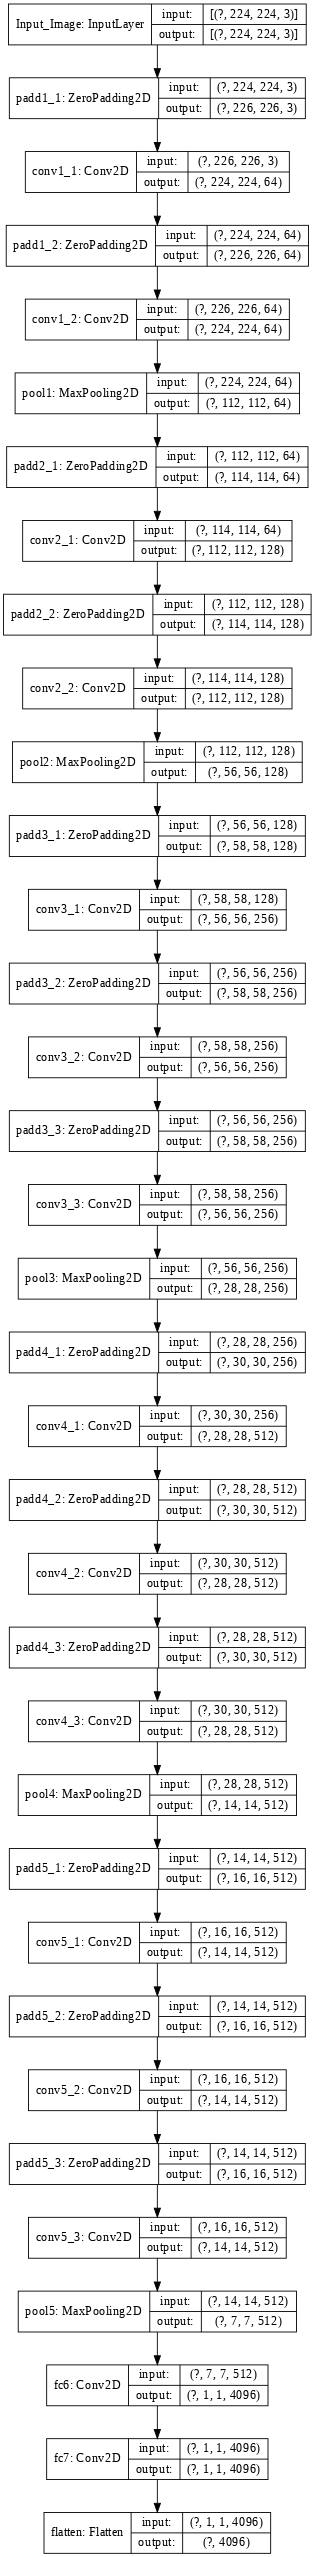

In [4]:
# create the model
base_model = VGG(image_shape=(224, 224, 3))

# plot the model
tf.keras.utils.plot_model(base_model, show_shapes=True, show_layer_names=True, dpi=64)

## Loading Weights

In [5]:
URL = "https://m-training.s3-us-west-2.amazonaws.com/dlchallenge/vgg_face_matconvnet.tar.gz"
path_to_zip = tf.keras.utils.get_file('vgg_face_matconvnet.tar', origin=URL, extract=True)
PATH_MODEL = os.path.join(os.path.dirname(path_to_zip), 'vgg_face_matconvnet/data')
data = loadmat(PATH_MODEL + '/vgg_face.mat', matlab_compatible=False, struct_as_record=False)
data

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Oct 13 16:54:01 2015',
 '__version__': '1.0',
 'net': array([[<scipy.io.matlab.mio5_params.mat_struct object at 0x7fc4f20a29e8>]],
       dtype=object)}

In [6]:
# the net object stores mat_struct object.
net = data['net'][0][0]

# Net object contains classes, layers and normalization sub objects. 
# Classes and normalization are discarded because weights are stored in layers.
ref_model_layers = net.layers[0]
print("Shape of reference model layer: ", ref_model_layers.shape)

for layer in ref_model_layers:
    print(layer[0][0].name)

Shape of reference model layer:  (39,)
['conv1_1']
['relu1_1']
['conv1_2']
['relu1_2']
['pool1']
['conv2_1']
['relu2_1']
['conv2_2']
['relu2_2']
['pool2']
['conv3_1']
['relu3_1']
['conv3_2']
['relu3_2']
['conv3_3']
['relu3_3']
['pool3']
['conv4_1']
['relu4_1']
['conv4_2']
['relu4_2']
['conv4_3']
['relu4_3']
['pool4']
['conv5_1']
['relu5_1']
['conv5_2']
['relu5_2']
['conv5_3']
['relu5_3']
['pool5']
['fc6']
['relu6']
['dropout6']
['fc7']
['relu7']
['dropout7']
['fc8']
['softmax']


In [7]:
for layer in base_model.layers:
  layer_name = layer.name
  try:
    print(layer_name,": ", layer.weights[0].shape)
  except:
    print("",end='')

conv1_1 :  (3, 3, 3, 64)
conv1_2 :  (3, 3, 64, 64)
conv2_1 :  (3, 3, 64, 128)
conv2_2 :  (3, 3, 128, 128)
conv3_1 :  (3, 3, 128, 256)
conv3_2 :  (3, 3, 256, 256)
conv3_3 :  (3, 3, 256, 256)
conv4_1 :  (3, 3, 256, 512)
conv4_2 :  (3, 3, 512, 512)
conv4_3 :  (3, 3, 512, 512)
conv5_1 :  (3, 3, 512, 512)
conv5_2 :  (3, 3, 512, 512)
conv5_3 :  (3, 3, 512, 512)
fc6 :  (7, 7, 512, 4096)
fc7 :  (1, 1, 4096, 4096)


In [8]:
for i in range(ref_model_layers.shape[0]):
  ref_model_layer = ref_model_layers[i][0,0].name[0]
  try:
    weights = ref_model_layers[i][0,0].weights[0,0]
    print(ref_model_layer,": ",weights.shape)
  except:
    print("",end='')

conv1_1 :  (3, 3, 3, 64)
conv1_2 :  (3, 3, 64, 64)
conv2_1 :  (3, 3, 64, 128)
conv2_2 :  (3, 3, 128, 128)
conv3_1 :  (3, 3, 128, 256)
conv3_2 :  (3, 3, 256, 256)
conv3_3 :  (3, 3, 256, 256)
conv4_1 :  (3, 3, 256, 512)
conv4_2 :  (3, 3, 512, 512)
conv4_3 :  (3, 3, 512, 512)
conv5_1 :  (3, 3, 512, 512)
conv5_2 :  (3, 3, 512, 512)
conv5_3 :  (3, 3, 512, 512)
fc6 :  (7, 7, 512, 4096)
fc7 :  (1, 1, 4096, 4096)
fc8 :  (1, 1, 4096, 2622)


### Setting weights

Just convolution and fully connected layers have weights. Trying to access weights for the rest of layers such as pooling or relu will cause exception. 

In [9]:
base_model_layer_names = [layer.name for layer in base_model.layers]
num_of_ref_model_layers = ref_model_layers.shape[0]
for i in range(num_of_ref_model_layers):
  ref_model_layer = ref_model_layers[i][0][0].name[0]
  # print(ref_model_layer)
  if ref_model_layer in base_model_layer_names:
    if ref_model_layer.find("conv") == 0 or ref_model_layer.find("fc") == 0:
      print(i, ". ", ref_model_layer)
      
      base_model_index = base_model_layer_names.index(ref_model_layer)
      weights = ref_model_layers[i][0][0].weights[0,0]
      bias = ref_model_layers[i][0][0].weights[0,1]

      base_model.layers[base_model_index].set_weights([weights, bias[:,0]])

0 .  conv1_1
2 .  conv1_2
5 .  conv2_1
7 .  conv2_2
10 .  conv3_1
12 .  conv3_2
14 .  conv3_3
17 .  conv4_1
19 .  conv4_2
21 .  conv4_3
24 .  conv5_1
26 .  conv5_2
28 .  conv5_3
31 .  fc6
34 .  fc7


 Now base model has weights in Keras format

## Data Preprocessing


### Data Download

In [10]:
_URL = "https://s3.amazonaws.com/matroid-web/datasets/agegender_cleaned.tar.gz"
path_to_zip = tf.keras.utils.get_file(
    fname=os.path.basename(_URL), 
    origin=_URL, 
    extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'combined')
data_dir = pathlib.Path(PATH)

In [11]:
BATCH_SIZE = 64 if _GPU else 32
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [12]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*/*.jpg'), shuffle=True)
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/combined/aligned/54_M/nm0000154_rm2057539328_1956-1-3_2010.jpg'
b'/root/.keras/datasets/combined/aligned/55_F/2221380_1951-02-20_2006.jpg'
b'/root/.keras/datasets/combined/aligned/49_F/nm0272677_rm969134592_1964-6-28_2013.jpg'
b'/root/.keras/datasets/combined/valid/11_M/landmark_aligned_face.1050.11489543156_4284de3505_o.jpg'
b'/root/.keras/datasets/combined/aligned/13_F/landmark_aligned_face.2223.11539194025_d29ac1de32_o.jpg'


### Map it over the dataset

In [13]:
class_names = np.array(sorted([item.name for item in pathlib.Path(os.path.join(data_dir, "aligned")).glob("*M")]))

def preprocess_image(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img)
  img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
  return img

# Reads an image from a file, decodes it into a dense tensor, and resizes it to a fixed shape.
def parse_image(file_path):

  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  one_hot = tf.dtypes.cast(one_hot, tf.uint8)
  label = tf.reduce_max(one_hot)

  # load the raw data from the file as a string
  image = tf.io.read_file(file_path)
  image = preprocess_image(image)

  return image, label

In [14]:
image_count = len(list_ds)
print(image_count)

33118


In [15]:
val_size = int(image_count * 0.15)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

28151
4967


In [17]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(parse_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(parse_image, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  0


### Configure dataset for performance

In [18]:
def configure_for_performance(ds):
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### Visualize the data

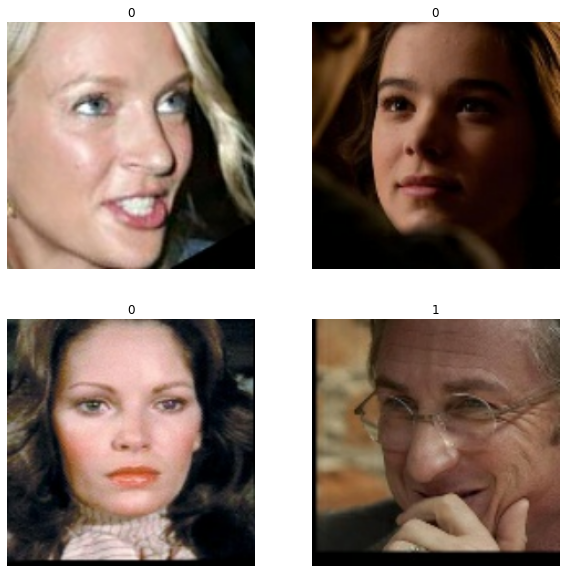

In [19]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(label.numpy())
  plt.axis("off")

### Data Augmentation

In [20]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(
      factor=0.1, fill_mode="constant")], 
      name="data_aug")

# Normalize input from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = tf.keras.layers.experimental.preprocessing.Normalization(name="Norm")
mean = np.array([127.5] * 3)
var = mean ** 2

## Feature Extraction

In [31]:
# Freeze base model
base_model.trainable = False

input = tf.keras.Input(shape=(224, 224, 3), name="input")
x = data_augmentation(input)
x = norm_layer(x) # Scale inputs to [-1, +1]
norm_layer.set_weights([mean, var])
x = base_model(x, training=False)
if _GPU:
  x = tf.keras.layers.Dense(2048, activation="relu", name="dense1")(x)
  x = tf.keras.layers.Dropout(rate=0.5, name="dropout1")(x)
  x = tf.keras.layers.Dense(1024, activation="relu", name="dense2")(x)
  x = tf.keras.layers.Dropout(rate=0.5, name="dropout2")(x)
outputs = tf.keras.layers.Dense(1, name="output")(x)

model = tf.keras.Model(input, outputs, name="Gender_Classifier")

model.summary()

Model: "Gender_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_aug (Sequential)        (None, 224, 224, 3)       0         
_________________________________________________________________
Norm (Normalization)         (None, 224, 224, 3)       7         
_________________________________________________________________
VGG (Functional)             (None, 4096)              134260544 
_________________________________________________________________
output (Dense)               (None, 1)                 4097      
Total params: 134,264,648
Trainable params: 4,097
Non-trainable params: 134,260,551
_________________________________________________________________


# Compile the model

## Train and Evaluate

In [32]:
class History:
  def __init__(self, smoothing_factor=0.0):
    self.alpha = smoothing_factor
    self.data = []
  def append(self, value):
    self.data.append( self.alpha*self.data[-1] + (1-self.alpha)*value if len(self.data)>0 else value )
  def get(self):
    return self.data

@tf.function
def train_step(image, label):
  # Open a GradientTape.
  with tf.GradientTape() as tape:
    # Forward pass.
    logits = model(image, training=True)
    # Compute the loss value for this batch.
    loss_value = loss_fn(label, logits)
    
  # Get gradients of loss wrt the *trainable* weights.
  grads = tape.gradient(loss_value, model.trainable_weights)

  # Update the weights of the model.
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  # Compare predicted label to actual label
  train_accuracy.update_state(label, logits)
  return loss_value

@tf.function
def val_step(image, label):
    val_logits = model(image, training=False)

    # Compare predicted label to actual label
    val_accuracy.update_state(label, val_logits)

In [33]:
EPOCHS = 3 if _GPU else 1

initial_learning_rate = 1e-1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.95,
    staircase=True)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_history = History(smoothing_factor=0.99) # to record loss evolution
acc_history = History(smoothing_factor=0.99) # to record accuracy evolution

train_accuracy = tf.keras.metrics.BinaryAccuracy()
val_accuracy = tf.keras.metrics.BinaryAccuracy()

# Keep results for plotting
train_accuracy_results = [0]
val_accuracy_results = [0]

for epoch in range(EPOCHS):

  print("\nStart of epoch %d" % (epoch+1,))
  start_time = time.time()

  # Iterate over the batches of a dataset.
  for step, (images, labels) in enumerate(train_ds):
    loss_value = train_step(images, labels)
    
    # Record the loss and accuracy evolution as a function of training 
    loss_history.append(loss_value.numpy().mean())
    acc_history.append(train_accuracy.result())
    
    # Log every 200 batches.
    temp = step % 200 if _GPU else step % 100
    if temp == 0:
      print("Training loss (for one batch) at step %d: %.4f" % (step, float(loss_value)))
      print("Seen so far: %d samples" % ((step + 1) * BATCH_SIZE))
  
  for image_val, label_val in val_ds:
    val_step(image_val, label_val)
  
  train_accuracy_results.append(train_accuracy.result())
  val_accuracy_results.append(val_accuracy.result())
  
  # Display metrics at the end of each epoch.
  print("Train Accuracy: {:.3%}, Val Accuracy: {:.3%}".format(
        train_accuracy.result(),
        val_accuracy.result()))
  print("Time taken: %.2fs" % (time.time() - start_time))

  # Reset training metrics at the end of each epoch
  train_accuracy.reset_states()
  val_accuracy.reset_states()


Start of epoch 1
Training loss (for one batch) at step 0: 0.6919
Seen so far: 32 samples
Training loss (for one batch) at step 100: 0.1662
Seen so far: 3232 samples
Training loss (for one batch) at step 200: 0.0625
Seen so far: 6432 samples
Training loss (for one batch) at step 300: 0.2041
Seen so far: 9632 samples
Training loss (for one batch) at step 400: 0.0267
Seen so far: 12832 samples
Training loss (for one batch) at step 500: 0.0660
Seen so far: 16032 samples
Training loss (for one batch) at step 600: 0.1120
Seen so far: 19232 samples
Training loss (for one batch) at step 700: 0.3866
Seen so far: 22432 samples
Training loss (for one batch) at step 800: 0.1725
Seen so far: 25632 samples
Train Accuracy: 93.884%, Val Accuracy: 96.715%
Time taken: 198.58s


## Visualize the loss function over time

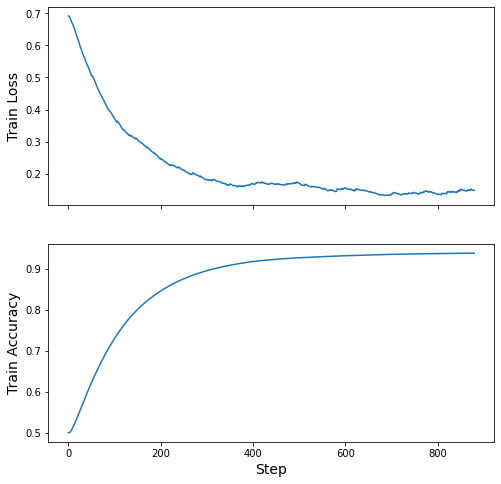

In [34]:
fig, axes = plt.subplots(2, sharex=True, figsize=(8, 8))

axes[0].set_ylabel("Train Loss", fontsize=14)
axes[0].plot(loss_history.get())

axes[1].set_ylabel("Train Accuracy", fontsize=14)
axes[1].set_xlabel("Step", fontsize=14)
axes[1].plot(acc_history.get())
plt.show()

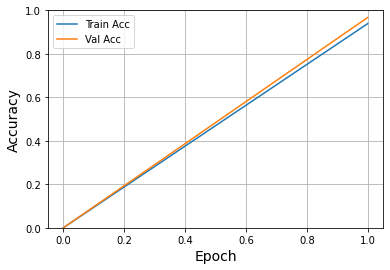

In [35]:
plt.figure()
plt.plot(train_accuracy_results, label="Train Acc")
plt.plot(val_accuracy_results, label="Val Acc")
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid("On")
plt.ylim([0, 1])
plt.legend()
plt.show()

### Visualize exponential learning rate

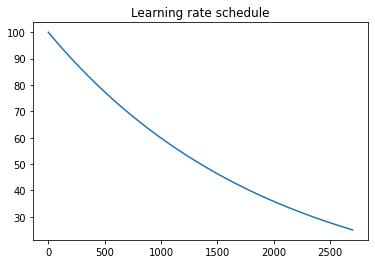

In [36]:
initial_learning_rate = 1e-1
decay_rate = 0.95
decay_steps = 100
decayed_learning_rate = lambda step: initial_learning_rate * decay_rate ** (step / decay_steps)

steps = np.linspace(0, 2700, 1000)
lr = decayed_learning_rate(steps)*1000

plt.figure()
plt.plot(steps, lr)
plt.title("Learning rate schedule")
plt.show()

## Save the entire model

In [37]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('VGG_GENDER.h5') 

In [38]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('VGG_GENDER.h5')

# Show the model architecture
new_model.summary()

Model: "Gender_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_aug (Sequential)        (None, 224, 224, 3)       0         
_________________________________________________________________
Norm (Normalization)         (None, 224, 224, 3)       7         
_________________________________________________________________
VGG (Functional)             (None, 4096)              134260544 
_________________________________________________________________
output (Dense)               (None, 1)                 4097      
Total params: 134,264,648
Trainable params: 4,097
Non-trainable params: 134,260,551
_________________________________________________________________


## Evaluate on test image

In [39]:
# Load test image
img_path = os.path.join(os.path.dirname(PATH_MODEL), "ak.jpg") 
image = tf.io.read_file(img_path)
image = preprocess_image(image)

Predictions: Male
Labels: Male


(-0.5, 223.5, 223.5, -0.5)

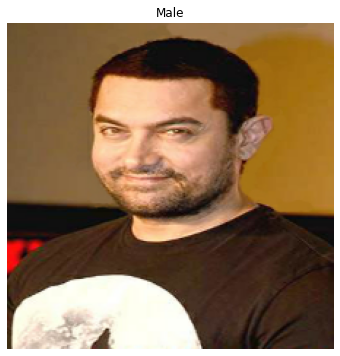

In [40]:
# Evaluate image type
logits = model(image, training=False)
label = tf.constant([1])
loss_value = loss_fn(label, logits)

# Apply a sigmoid since our model returns logits
pred = tf.nn.sigmoid(logits)
predictions = tf.where(pred < 0.5, 0, 1)
predictions = tf.squeeze(predictions)
predictions = np.where(predictions.numpy() < 0.5, "Female", "Male")
label = np.where(label.numpy()[0] == 0, "Female", "Male")
print('Predictions:', predictions)
print('Labels:', label)

plt.figure(figsize=(6, 6))
plt.imshow(image.numpy().astype("uint8"))
plt.title(predictions)
plt.axis("off")